In [ ]:
import numpy as np


def PETPT(tmax, tmin, srad, xhlai, msalb):


    td = 0.6*tmax + 0.4*tmin

    if xhlai < 0.0:
        albedo = msalb
    else:
        albedo = 0.23 - (0.23 - msalb)*np.exp(-0.75*xhlai)


    slang = srad*23.923
    eeq = slang*(2.04*pow(10, -4)-1.83*pow(10, -4)*albedo)*(td+29.0)
    eo = eeq*1.1

    if tmax > 35.0:
        eo = eeq*((tmax-35.0)*0.05 + 1.1)
    elif tmax < 5.0:
        eo = eeq*0.01*np.exp(0.18*(tmax+20.0))
    eo = max(eo, 0.0001)


    return eo

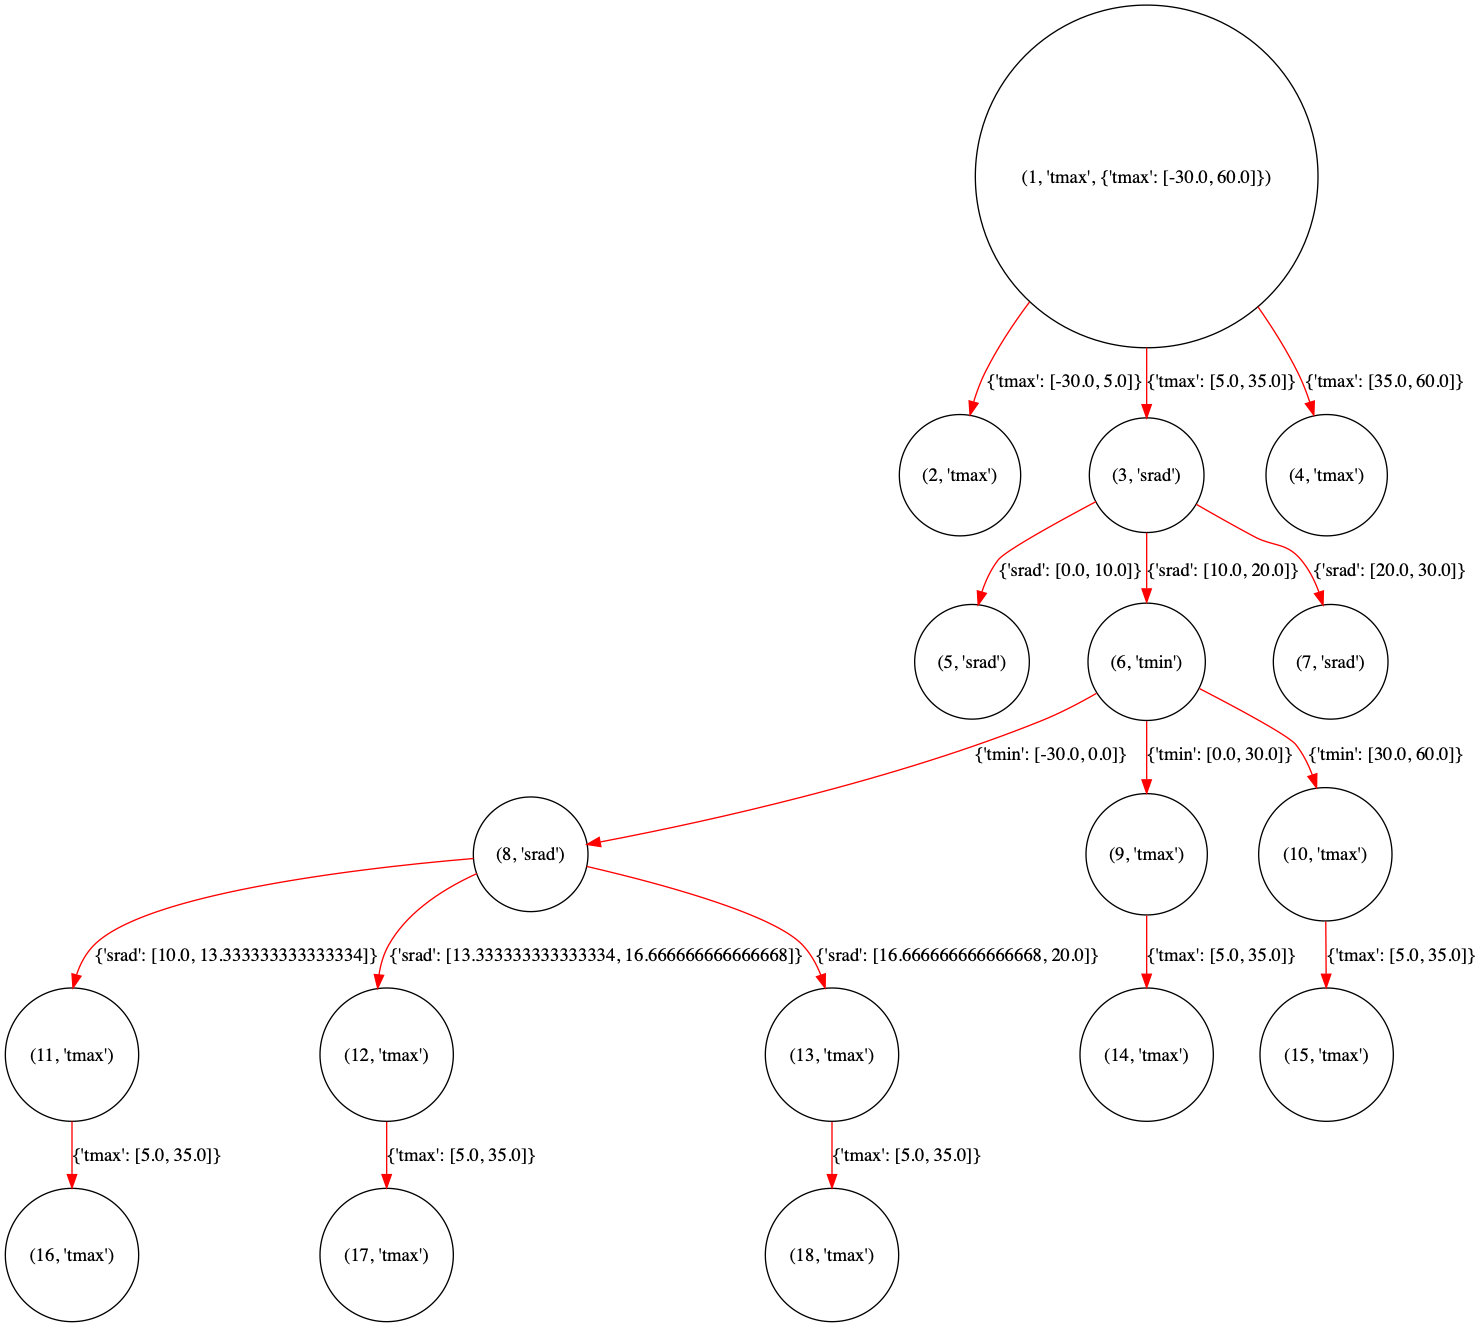

In [3]:
from IPython.display import Image 

Image('PETPT.png', width=1000,  height=1000)